## Exploratory Data Analysis

#### Load packages and data

In [1]:
# LOAD PACKAGES
import os 
from tqdm import notebook
import pathlib
import pickle as pkl
import matplotlib
import gdown
import itertools
from pooch import DOIDownloader

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import re
from data_preperation import *

In [ ]:
# DOWNLOAD DATA FROM WEB
download_shormccarty()
download_chorus()

In [2]:
# LOAD DATA FROM FILE 
chorus_folder = "../data/raw/chorus"
bills = pd.read_parquet(os.path.join(chorus_folder, "bills.parquet"))
positions = pd.read_parquet(os.path.join(chorus_folder, "positions.parquet"))
blocks = pd.read_parquet(os.path.join(chorus_folder, "block_assignments.parquet"))

ideology = pd.read_csv("../data/raw/shormccarty/state_ideology.tab", sep='\t')

#### Subset data
- States with lobbying records: ["IA", "MA", "NE", "NJ", "RI", "WI"] 
- Years where all relevant data (ideology, positions, bills) is available for each state: 
    - IA: 2009-2020
    - MA: 2009-2020
    - NE: 2010-2020
    - NJ: 2014-2020
    - RI: 2018-2020
    - WI: 2009-2020

In [4]:
states_lobby = ["IA", "MA", "NE", "NJ", "RI", "WI"] 
state_name_dicts = dict(zip(states_lobby, ["iowa", "massachusetts", "nebraska", "new jersey", "rhode island", "wisconsin"]))
time_ranges = [range(2009, 2021), range(2009, 2021), range(2010, 2021), 
               range(2014, 2021), range(2018, 2021), range(2009, 2021)]
states_palette = dict(zip(states_lobby, sns.color_palette("viridis", 6).as_hex())) #palette for plots
states_markers = dict(zip(states_lobby, ['o', 'D', 's','P', 'X',  'd']))

##### BILLS

In [5]:
#BILLS:
bills_sub = clean_bills(bills, states_lobby, time_ranges, state_name_dicts)
print(f"Total number of samples (bills) after cleaning: {len(bills_sub)}\n")
print(f"Proportion of bills passed and failed:\n{bills_sub["pass"].value_counts(normalize = True)}\n")
print(f"Number of bills passed and failed:\n{bills_sub["pass"].value_counts()}")
print(f"\nProportion of bills with one or more assigned metatopics:\n{bills_sub["ncsl_metatopics"].apply(lambda x: "no NCSL topics" if x == ["M"]  else "assigned NCSL topic").value_counts(normalize=True)}")

bills cleaned
Total number of samples (bills) after cleaning: 127829

Proportion of bills passed and failed:
pass
failed    0.880254
passed    0.119746
Name: proportion, dtype: float64

Number of bills passed and failed:
pass
failed    112522
passed     15307
Name: count, dtype: int64

Proportion of bills with one or more assigned metatopics:
ncsl_metatopics
no NCSL topics         0.84254
assigned NCSL topic    0.15746
Name: proportion, dtype: float64


In [6]:
print(f"\nSamples (bills) per state and status:\n{bills_sub.value_counts(["state", "pass"], sort=False).T}")


Samples (bills) per state and status:
state  pass  
IA     failed    15634
       passed     1831
MA     failed    40258
       passed     3163
NE     failed     5673
       passed     3648
NJ     failed    36380
       passed     2444
RI     failed     4612
       passed     2212
WI     failed     9965
       passed     2009
Name: count, dtype: int64


In [ ]:
#PLOT BILLS: STATUS
fig, ax = plt.subplots(figsize=(6, 4))
p = sns.countplot(bills_sub, x = "state", hue = "pass",stat = "count", palette= "viridis")
sns.move_legend(p, "upper right", frameon = False, title=None)
ax.set_title('Number of Bills per State and Status')
sns.despine()
plt.savefig("../out/figs/bills_status.png", bbox_inches='tight', dpi = 1000)

In [ ]:
#PLOT BILLS: COUNTS (LINEPLOT)
fig, ax = plt.subplots(figsize=(10, 4))
p = sns.lineplot(data = bills_sub.value_counts(["state", "year"]).to_frame().reset_index(), 
                 x = "year", y = "count", hue = "state", palette= states_palette, 
                 style="state", markers=states_markers, dashes=False)
sns.move_legend(p, "upper right", bbox_to_anchor=(1.1, 0.7),  frameon = False)
sns.despine()
ax.set_title('Number of Bills per State and Year')
plt.xticks([2009., 2010., 2011., 2012., 2013., 2014., 2015., 2016., 2017., 2018., 2019., 2020.],
           ['2009', '2010', '2011', '2012', '2013', '2014', '2015','2016','2017','2018','2019','2020'])
plt.savefig("../out/figs/bills_lineplot.png", bbox_inches='tight', dpi = 1000)

In [ ]:
#PLOT BILLS: COUNTS (BARPLOT)
fig, ax = plt.subplots(figsize=(7, 4))
p = sns.countplot(bills_sub, x="year", hue="state", stat="count", palette=states_palette, gap=.15)
sns.move_legend(p, "upper center", bbox_to_anchor=(0.5, 1.1), ncol=6,  frameon=False, title=None)
ax.set_title('Number of Bills per State and Year', y=1.1)
sns.despine()
plt.savefig("../out/figs/bills_barplot.png", bbox_inches='tight', dpi=1000)

In [ ]:
#PLOT BILLS: NCSL METATOPICS IN TOTAL
print(f"number of unique metatopics: {len(bills_sub["ncsl_metatopics"].explode().unique())}")
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(y=bills_sub["ncsl_metatopics"].explode(), hue=bills_sub["ncsl_metatopics"].explode(),
              order = bills_sub["ncsl_metatopics"].explode().unique()[::-1], palette="viridis")
sns.despine()
ax.set_title('Distribution of NCSL metatopics')
ax.set_yticklabels(np.append(bills_sub["ncsl_metatopics"].explode().unique()[::-1][0:-1], "No NCSL metatopic assigned"))
plt.ylabel("")
plt.savefig("../out/figs/metatopic_counts.png", bbox_inches='tight', dpi=1000)

##### IDEOLOGY

In [7]:
#IDEOLOGY
bills_ide = clean_ideology(ideology, bills_sub, states_lobby)
#save summary stats 
round(bills_ide[["state", "year", "chamber", "dem", "rep", "majority", "minority", "dem_mean", 
           "rep_mean", "diffs", "distance"]].describe(), 3).to_csv(
            "../out/ideology_summary.txt", sep="\t")

ideology cleaned


##### POSITIONS

In [8]:
#POSITIONS
positions_sub = clean_positions(positions, bills_sub, states_lobby, time_ranges)

positions cleaned


In [ ]:
#PLOTS: COUNTS (LINEPLOT)
fig, ax = plt.subplots(figsize=(10, 4))
p = sns.lineplot(data = positions_sub.value_counts(["state", "year"]).to_frame().reset_index(), 
                 x = "year", y = "count", hue = "state", palette= states_palette, style="state",
                 markers=states_markers, dashes=False)
sns.move_legend(p, "upper right", bbox_to_anchor=(1.1, 0.7),  frameon = False)
sns.despine()
ax.set_title('Number of Positions per State and Year')
plt.xticks([2009., 2010., 2011., 2012., 2013., 2014., 2015., 2016., 2017., 2018., 2019., 2020.],
           ['2009', '2010', '2011', '2012', '2013', '2014', '2015','2016','2017','2018','2019','2020'])
plt.savefig("../out/figs/positions_lineplot.png", bbox_inches='tight', dpi=1000)

In [ ]:
#PLOT: COUNT (BARPLOT)
fig, ax = plt.subplots(figsize=(7, 4))
p = sns.countplot(positions_sub, x="year", hue="state", stat="count", palette=states_palette, gap=.15)
sns.move_legend(p, "upper center", bbox_to_anchor=(0.5, 1.1), ncol=6,  frameon=False, title=None)
ax.set_title('Number of Positions per State and Year', y = 1.1)
sns.despine()
plt.savefig("../out/figs/positions_barplot.png", bbox_inches='tight', dpi=1000)

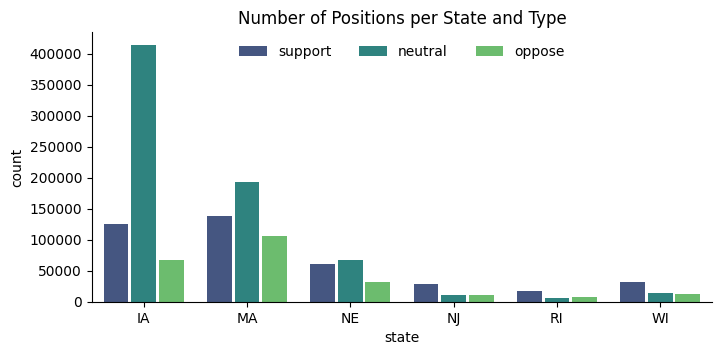

In [14]:
# PLOT: POSITIONS TYPE
fig, ax = plt.subplots(figsize=(8, 3.5))
p = sns.countplot(positions_sub, x="state", hue="position_numeric", stat="count", palette="viridis", gap =.1)
sns.move_legend(p, "upper center",  bbox_to_anchor=(0.5, 1), ncol=3,  frameon = False, title=None)
ax.set_title('Number of Positions per State and Type', y=1)
sns.despine()
plt.savefig("../out/figs/position_type.png", bbox_inches='tight', dpi=1000)

In [69]:
pos_counts = pd.DataFrame(positions_sub.value_counts(["state_unified_bill_id", "state"])).reset_index().rename(columns={'count':'position_count'})
print(f"Number of bills with positions after removing outliers above 400: {len(pos_counts[pos_counts["position_count"]<400])}")
print(f"Number of bills with counts above 400: {len(pos_counts)-70751}\nMax value: {pos_counts["position_count"].max()}")


Number of bills with positions after removing outliers above 400: 70751
Number of bills with counts above 400: 56
Max value: 962


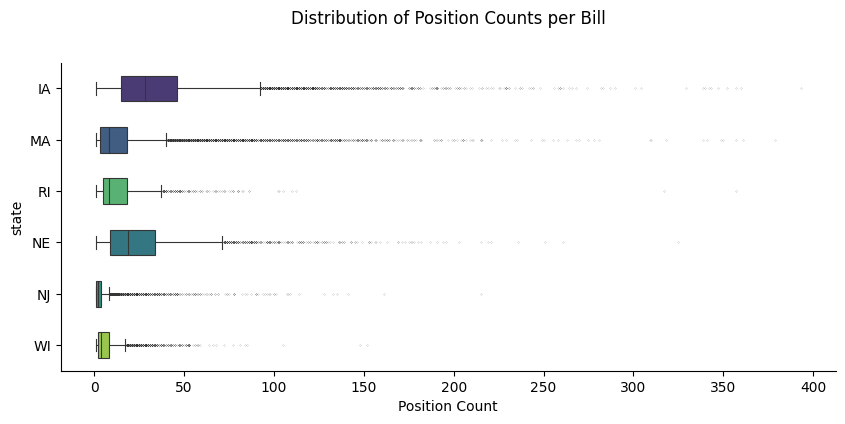

In [63]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(data=pos_counts[pos_counts["position_count"]<400], 
            y="state", x="position_count", hue="state", palette= states_palette, 
            fliersize =.1, width=0.5, linewidth=0.8)
ax.set_title('Distribution of Position Counts per Bill', y=1.1)
ax.set_xlabel("Position Count")
sns.despine()
plt.savefig("../out/figs/position_dist.png", bbox_inches='tight', dpi=1000)

##### BLOCKS

In [ ]:
#BLOCKS
positions_blocks = clean_blocks(blocks, positions_sub, states_lobby)
print(f"number of positions in total after cleaning: {len(positions_blocks)}")
print(f"total number of unique blocks: {len(positions_blocks["block"].unique())}")

In [ ]:
#create block count df for overvoew of client dists
block_counts = pd.DataFrame(positions_blocks.drop_duplicates("state_client_id").value_counts("block", sort=False)).reset_index()
block_counts["state"] = block_counts["block"].apply(lambda x: x.split("_")[0])

In [ ]:
#PLOT CLIENTS PER BLOCK
fig, ax = plt.subplots(figsize=(14, 4))
p = sns.barplot(block_counts, x="block", y="count", hue="state", palette=states_palette)
sns.despine()
sns.move_legend(p, "lower center",  bbox_to_anchor=(0.5, -0.3), ncol=6,  frameon=False, title=None)
ax.set_title('Number of Clients per Block Assignment')
plt.tick_params(axis="x", labelsize=4, labelrotation=90)
plt.savefig("../out/figs/clients_counts.png", bbox_inches='tight', dpi=1000)

##### MERGE DATASETS: 
bills_ide & positions_blocks

In [ ]:
##prep block counts for merge:
#block_array, block1_ls, bill_ls = extract_block_counts(bills_ide, positions_blocks)
